# XGBoost to predict discharge disability: Set of six binary XGBoost models to predict whether a patient is at least as well as mRS0, mRS1, mRS2. mRS3. mRS4 and mRS5.

Updating the approach based on the conversations with MA on 27 June 2024. Namely:
* Use kfolds for the accuracy
* Use the first kfold for results (same as before)
* feature selection based on other paper (same as before)
* counterfactuals – just use patients that received thrombolysis. What is the benefit in the population that receive IVT? Using full SHAP value and not main effect, so including the interactions. (same as before)
* Set value of feature "onset_to_thrombolysis_time" to 999999 as a surrogate for not receiving treatment.
* Use patient for the waterfall plots (mRS<=1) that spans the 0 SHAP value wehn have treatment or not (w/o treatment <0, with treatment >0)
* For paper have the set of global SHAP values for one threshold (mRS<=1), and the full set for one feature (either stroke severity or OTT - include the base value for each threshold model)
* Use common x axis range for the hospital SHAP hitograms. 
* Plots for probability with and without treatment for each mRS threshold: i. Add no effect line. ii. Single patient flowing up the charts. iii. No colour points in the charts.
* Table of stats model for the regressions

### Plain English summary

Train binary models, converting the target feature (disability_discharge) into a binary feature by predicting whether the patient is at least as well as each mRS level.

Use just first kfold as seen performance of model is consistent across the 5 kfold splits.

Each binary model is trained using the same 7 features as used in the multiclass classification model: "prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known".

### Model and data

Model: Set of 6 binary XGBoost classification models, predicting whether patient is at least as well as each mRS level at discharge.\
Target feature: At least as well as each mRS level (binary feature)\
Input features: 7 selected features\
Kfold split: first kfold split

### Aims

What patterns can be found fitting models to if at least as good as a mRS level.

### Observations

SHAP plots are easier to interpret, as it is always better for the patient to have a positive SHAP (to be in the lower mRS level). For the multiclass classification model, for the outcome mRS3, you'd want to be mRS3 if the alternative is mRS4+, but not if the alternative is mRS0-2.

#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb




## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

Use the full 5 kfold split to test the accuracy of the models

In [3]:
n_kfold = 5

Values to use as the mRS thresholds to divide the target feature into a binary feature, and fit a model per binary target feature.

In [4]:
list_binary_thresholds = [0, 1, 2, 3, 4, 5]
n_binary_models = len(list_binary_thresholds)
surrogate_time_for_no_thrombolysis = 9999

Select the features for the model

In [5]:
target_feature = 'discharge_disability'

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [6]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = (f'xgb_all_features_{n_kfold}fold'
                       f'_binary')
    notebook: str = '073_'

paths = Paths()


Create output folders if needed

In [7]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

Import data for all of the 5 kfold splits.

Put target feature in one Dataframe, and the oth features to be used as the input features in another Dataframe.

In [8]:
X_train_kfold, y_train_kfold, X_test_kfold, y_test_kfold = [], [], [], []

for k in range(n_kfold):
    # Read in training set, restrict to chosen features & store
    filename = os.path.join(paths.data_read_path, 
                            ('03_train_' + str(k) + '.csv'))
    train = pd.read_csv(filename)
    y_train = train[target_feature]
    X_train = train.drop(target_feature, axis=1, inplace=False)
    X_train_kfold.append(X_train)
    y_train_kfold.append(y_train)

    # Read in test set, restrict to chosen features & store
    filename = os.path.join(paths.data_read_path, 
                            ('03_test_' + str(k) + '.csv'))
    test = pd.read_csv(filename)
    y_test = test[target_feature]
    X_test = test.drop(target_feature, axis=1, inplace=False)
    X_test_kfold.append(X_train)
    y_test_kfold.append(y_train)


Number of input features for the model (before one hot encode)

In [9]:
selected_features = list(X_train_kfold[0])
n_features = len(selected_features)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [10]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix=prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Keep copy of original 'stroke_team' data, before one-hot encoded

In [11]:
train_stroke_team_kfold, test_stroke_team_kfold = [], []
for k in range(n_kfold):
    train_stroke_team_kfold.append(X_train_kfold[k]["stroke_team"].values)
    test_stroke_team_kfold.append(X_test_kfold[k]["stroke_team"].values)

Set up two lists for the one hot encoding.

A list of the feature names that are categorical and to be converted using one hot encoding. A list of the prefixes to use for these features.

In [12]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [13]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        for k in range(n_kfold):
            X_train_kfold[k] = convert_feature_to_one_hot(X_train_kfold[k], feature, prefix)
            X_test_kfold[k] = convert_feature_to_one_hot(X_test_kfold[k], feature, prefix)

Feature names with one hot encoding (using data for kfold0)

In [14]:
feature_names_ohe = list(X_train_kfold[0])
n_features_ohe = len(feature_names_ohe)

In [15]:
print(f"There are {n_features} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 55 original features (before one-hot encoding)
There are 178 features (after one-hot encoding)


Crate a dataframe containing each of the target features for the different threshold values

In [16]:
def create_df_of_binary_target_features(target_feature_data, binary_thresholds):
    """ 
    Given a feature, return a dataframe of all of the different binary versions 
    depending on the threshold used

    Args:
        data [dataframe]: patient feature values
        target_feature [string]: feature name of target feature
        binary_thresholds [list]: list of thresholds to use for each version of 
                    a binary target feature

    Return:
        df [dataframe]: row per instance, column per threshold. Containing 
        feature values for patients with binary representation of the target 
        feature, based on the threshold value 
    
    """    
    df = pd.DataFrame()

    for threshold in binary_thresholds:
        binary_target_feature_name = f'{target_feature}_bin_{threshold}'

        # For the new feature, set all to 0    
        df[binary_target_feature_name] = 0

        # Then set to 1 those patients that are the threshold value or less
        df[binary_target_feature_name] = (
                                    (target_feature_data <= threshold) * 1)
        
    return(df)

Create dataframe of the binary target features, store in a list per kfold.

In [17]:
list_df_all_y_bin_train_kfold, list_df_all_y_bin_test_kfold = [], []

for k in range(n_kfold):
    list_df_all_y_bin_train_kfold.append(create_df_of_binary_target_features(
                                    y_train_kfold[k], list_binary_thresholds))
    list_df_all_y_bin_test_kfold.append(create_df_of_binary_target_features(
                                    y_test_kfold[k], list_binary_thresholds))

Plot barchart of proportion in each class for each of the thresholds

In [18]:
def plot_barchart(df_bin_target_feature):
    """
    
    Args:
        df_bin_target_feature [dataframe]: A column per target feature using a 
                      different threshold for a binary representation 
        
    Return:
        None    
    """  
    
    count_0 = []
    count_1 = []
    max_accuracy_if_majority = []
    n_instances = df_bin_target_feature.shape[0]
    columns = df_bin_target_feature.columns

    for col in columns:
        df_bin_target_feature[col]
        n_zeros = (df_bin_target_feature[col] == 0).sum()
        count_0.append(n_zeros)
        n_ones = (df_bin_target_feature[col] == 1).sum()
        count_1.append(n_ones)

        # If model predicted every instance was the majority class, what would 
        # the accuracy be
        max_accuracy = max(n_zeros/n_instances, n_ones/n_instances)
        max_accuracy_if_majority.append(round(max_accuracy*100, 1))

    # create data
    x = np.arange(len(count_1)).tolist()

    x_ticks = []
    for i in x:
        if i == 0:
            x_ticks.append(f"mRS0\n[{max_accuracy_if_majority[i]}%]") 
        else:
            x_ticks.append(f"mRS0-{i}\n[{max_accuracy_if_majority[i]}%]") 

    # plot bars in stack manner
    plt.bar(x, count_1, bottom=count_0, color='b', label="In specified mRS range")
    plt.bar(x, count_0, color='r', label="Not in specified mRS range")
    plt.xlabel("Target feature'\n[accuracy if "
               "all instances classified as majority class]")
    plt.ylabel("Count of patients")
    plt.xticks(x, x_ticks)
    plt.legend(bbox_to_anchor=(1.03, 1.0))
    plt.title(f"Frequency of test patients in each binary category,\n"
              f"for each threshold level (for kfold{k})")
    plt.show()
    return(max_accuracy_if_majority)

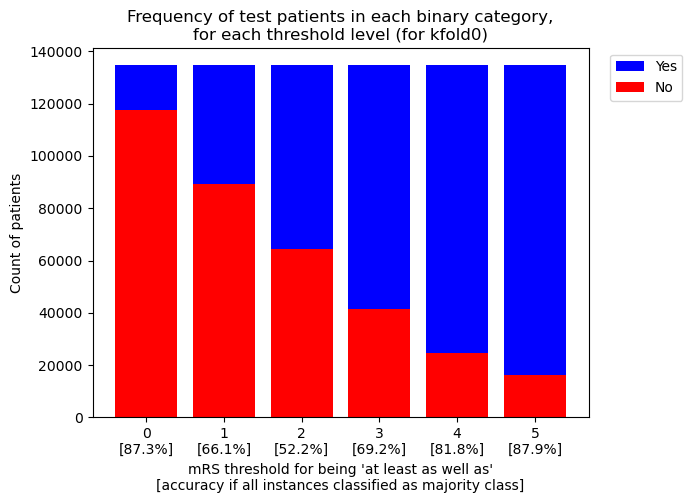

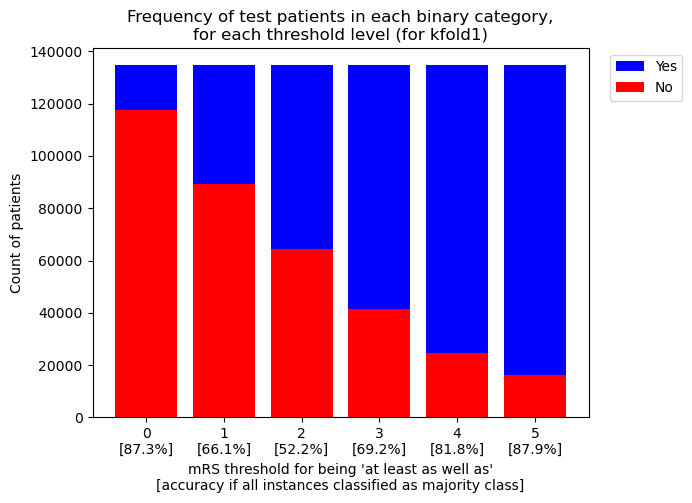

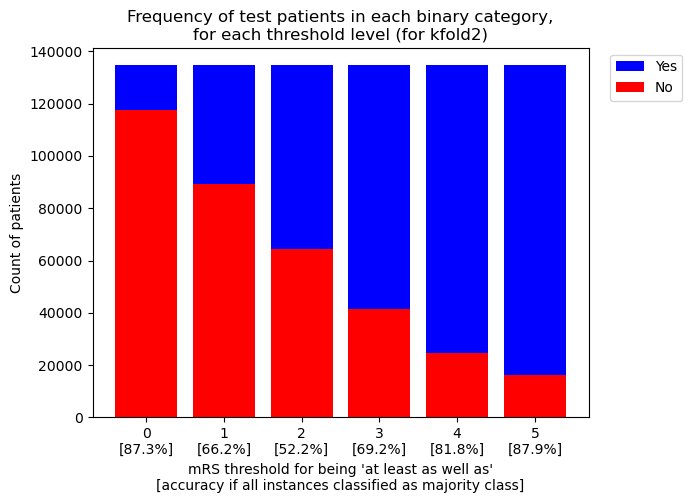

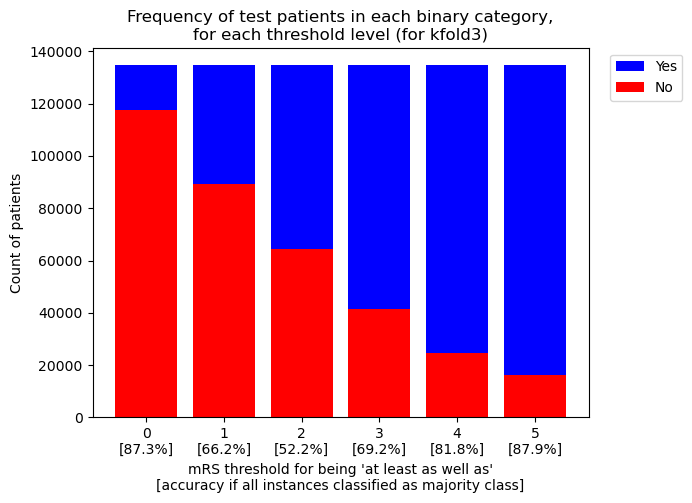

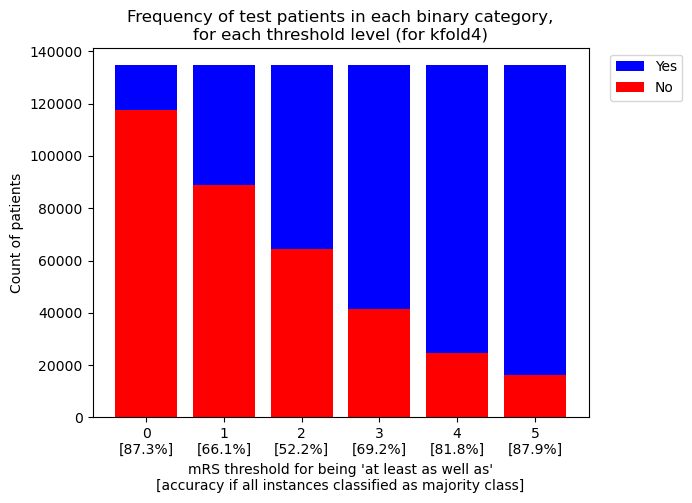

In [19]:
list_max_accuracy_if_majority_kfold = []

for k in range(n_kfold):
    list_max_accuracy_if_majority_kfold.append(plot_barchart(list_df_all_y_bin_test_kfold[k]))


Define function to fit XGBoost model

In [20]:
def fit_xgb_model(X_train, y_train, filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42)#, learning_rate=0.5,
#                                tree_method='gpu_hist')
        model.fit(X_train, y_train)

        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)

    return(model)

Define function to calculate preditions from model

In [21]:
def calculate_predicted_probabilities(model, X_data):
    """ 
    Given a model and input data, return the models probability and prediction
    for each instance.
    
    Args:
        model [xgboost classifier object]: trained model
        X_data [dataframe]: input features for model

    Return:
        y_probs [array]: the probability of being in each target feature class
        y_pred [array]: the prediction (the class with the largest probability)
    """

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_data)

    # Get and store predicted class
    y_pred = model.predict(X_data)

    return(y_probs, y_pred)

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load SHAP extended from pickle (if file exists), or calculate.

Create function to return SHAP values extended

In [22]:
def calculate_shap_extended(filename, model, X_train, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        filename [string]: name of file containing SHAP extended data
        model [xgboost classification model object]: xgboost object
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [object]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

Code to setup data per binary threshold, fit model and analyse performance

In [23]:
# Store all the results for the binary model (for the 5 kfolds)
dict_binary_model_results = {}

# Include the new binary feature we calculate (replaces the multiclass feature)
for binary_threshold in list_binary_thresholds:
    # Set up the target feature name for this threshold
    binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

    # Initialise lists
    y_pred_binary_kfold = []
    y_probs_binary_kfold = []
    shap_values_extended_kfold = []
    model_kfold = []
    accuracy_kfold = []
    feature_importance_kfold = []
    rocauc_kfold = []
    y_bin_test_kfold = []
    y_bin_train_kfold = []
    y_error_kfold = []

    for k in range(n_kfold):
        # Model filename
        filename = os.path.join(paths.model_save_path, 
                                    (paths.notebook + paths.model_text +  "_mrs" +
                                    str(binary_threshold) + '_kfold' + str(k) + '.p'))

        # Get target feature for this threshold
        y_bin_train_kfold.append(list_df_all_y_bin_train_kfold[k][binary_target_feature_name])

        ## Fit XGBoost model
        model_kfold.append(fit_xgb_model(X_train_kfold[k], y_bin_train_kfold[k], filename))

        # Store predictions for test dataset
        (y_probs, y_pred) = calculate_predicted_probabilities(model_kfold[k], X_test_kfold[k])
        y_pred_binary_kfold.append(y_pred)
        y_probs_binary_kfold.append(y_probs[:,1])
       
        # Get ROC AUC
        y_bin_test_kfold.append(list_df_all_y_bin_test_kfold[k][binary_target_feature_name])
        fpr, tpr, thresholds = roc_curve(y_bin_test_kfold[k], y_probs[:,1])
        rocauc_kfold.append(auc(fpr, tpr))

        # Calculate error
        y_error_kfold.append(y_bin_test_kfold[k] - y_pred)
        accuracy_kfold.append(np.mean(y_error_kfold[k]==0))

        # Get and store feature importances
        feature_importance_kfold.append(model_kfold[k].feature_importances_)

        # SHAP values extended
        # Set filename
        filename = os.path.join(paths.data_save_path, 
                             (paths.notebook + paths.model_text + "_mrs" +
                             str(binary_threshold) + '_kfold' + str(k) + 
                             '_shap_values_extended.p'))

        # Load or calculate SHAP extended
        shap_values_extended_kfold.append(calculate_shap_extended(
                                            filename, model_kfold[k], 
                                            X_train_kfold[k], 
                                            X_test_kfold[k]))

    # Print accuracy summary
    accuracy_mean = np.mean(accuracy_kfold)
    rocauc_mean =  np.mean(rocauc_kfold)
    print("***")
    print(f"Model using binary threshold {binary_threshold}")
    print("***")
    print()
    print (f'Accuracy: {accuracy_mean:0.3f} '
           f'(std across {n_kfold} kfolds: {np.std(accuracy_kfold):0.3f})')

    print (f'ROC AUC: {rocauc_mean:0.3f} '
           f'(std across {n_kfold} kfolds: {np.std(rocauc_kfold):0.3f})')
 
    print (f'(Accuracy if categorise all as majority class: ' +
            f'{list_max_accuracy_if_majority_kfold[k][binary_threshold]:0.3f})')
 
    print("***")
    print()

    # Save kfold results in dictionary for this threshold
    dict_binary_model_results[f"accuracy_kfold_list_mrs{binary_threshold}"] = accuracy_kfold
    dict_binary_model_results[f"rocauc_kfold_list_mrs{binary_threshold}"] = rocauc_kfold
    dict_binary_model_results[f"y_pred_kfold_list_mrs{binary_threshold}"] = y_pred_binary_kfold
    dict_binary_model_results[f"y_probs_kfold_list_mrs{binary_threshold}"] = y_probs_binary_kfold
    dict_binary_model_results[f"shap_values_extended_kfold_list_mrs{binary_threshold}"] = shap_values_extended_kfold
    dict_binary_model_results[f"model_kfold_list_mrs{binary_threshold}"] = model_kfold
    dict_binary_model_results[f"feature_importance_kfold_list_mrs{binary_threshold}"] = feature_importance_kfold
    dict_binary_model_results[f"y_bin_test_kfold_list_mrs{binary_threshold}"] = y_bin_test_kfold 
    dict_binary_model_results[f"y_bin_train_kfold_list_mrs{binary_threshold}"] = y_bin_train_kfold
    dict_binary_model_results[f"y_error_kfold_list_mrs{binary_threshold}"] = y_error_kfold

100%|===================| 134589/134678 [02:15<00:00]        

***
Model using binary threshold 0
***

Accuracy: 0.899 (std across 5 kfolds: 0.000)
ROC AUC: 0.908 (std across 5 kfolds: 0.001)
(Accuracy if categorise all as majority class: 87.300)
***



100%|===================| 134138/134678 [02:15<00:00]        

***
Model using binary threshold 1
***

Accuracy: 0.815 (std across 5 kfolds: 0.000)
ROC AUC: 0.894 (std across 5 kfolds: 0.000)
(Accuracy if categorise all as majority class: 66.100)
***



 99%|===================| 134004/134678 [01:55<00:00]        

***
Model using binary threshold 2
***

Accuracy: 0.832 (std across 5 kfolds: 0.000)
ROC AUC: 0.911 (std across 5 kfolds: 0.000)
(Accuracy if categorise all as majority class: 52.200)
***



 99%|===================| 133838/134678 [02:01<00:00]        

***
Model using binary threshold 3
***

Accuracy: 0.871 (std across 5 kfolds: 0.001)
ROC AUC: 0.925 (std across 5 kfolds: 0.001)
(Accuracy if categorise all as majority class: 69.200)
***



 99%|===================| 133883/134678 [02:15<00:00]        

***
Model using binary threshold 4
***

Accuracy: 0.906 (std across 5 kfolds: 0.000)
ROC AUC: 0.935 (std across 5 kfolds: 0.000)
(Accuracy if categorise all as majority class: 81.800)
***



 99%|===================| 133804/134678 [02:20<00:00]        

***
Model using binary threshold 5
***

Accuracy: 0.921 (std across 5 kfolds: 0.001)
ROC AUC: 0.926 (std across 5 kfolds: 0.001)
(Accuracy if categorise all as majority class: 87.900)
***



Checking the individual results for the 0 kfold here are the same as the 0kfold results in notebook 085.

(because 105 and 103 differ, and trying to work out why)

In [24]:
for binary_threshold in list_binary_thresholds:
    print(dict_binary_model_results[f"accuracy_kfold_list_mrs{binary_threshold}"])
print()
for binary_threshold in list_binary_thresholds:
    print(dict_binary_model_results[f"rocauc_kfold_list_mrs{binary_threshold}"])

[0.8990250748086162, 0.8987948944511683, 0.8994193557967893, 0.898491216085775, 0.8979566076122306]
[0.8152691253888934, 0.8152022988335054, 0.8158496562170511, 0.8152407965666256, 0.814624511798512]
[0.8324361249508082, 0.8312480972994647, 0.8322294658370335, 0.8319695867179495, 0.8317171327165536]
[0.8711881019030718, 0.8712178025943553, 0.870684150343783, 0.8711742081111986, 0.8692585277476648]
[0.9064131217654091, 0.9061161148525732, 0.9061019617160933, 0.9064954929535634, 0.9052703485350243]
[0.9218649064056966, 0.9198675349168752, 0.9221105154516699, 0.9214868055658683, 0.9203284872065223]

[0.9090157364416471, 0.9078971724132636, 0.9091742291448714, 0.9071491642627603, 0.9070959144137578]
[0.8940943427762059, 0.8932296841116623, 0.8940635135180253, 0.8940951104738758, 0.8936597613329524]
[0.9110898172069231, 0.9108180584167236, 0.911670487077069, 0.9114401926756038, 0.9110345829718911]
[0.9250863381307708, 0.9256820069682953, 0.9252549177679174, 0.9253481837241482, 0.92403444256

Confusion matrix for each binary threshold model

Resource (subplots with imshow): https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar

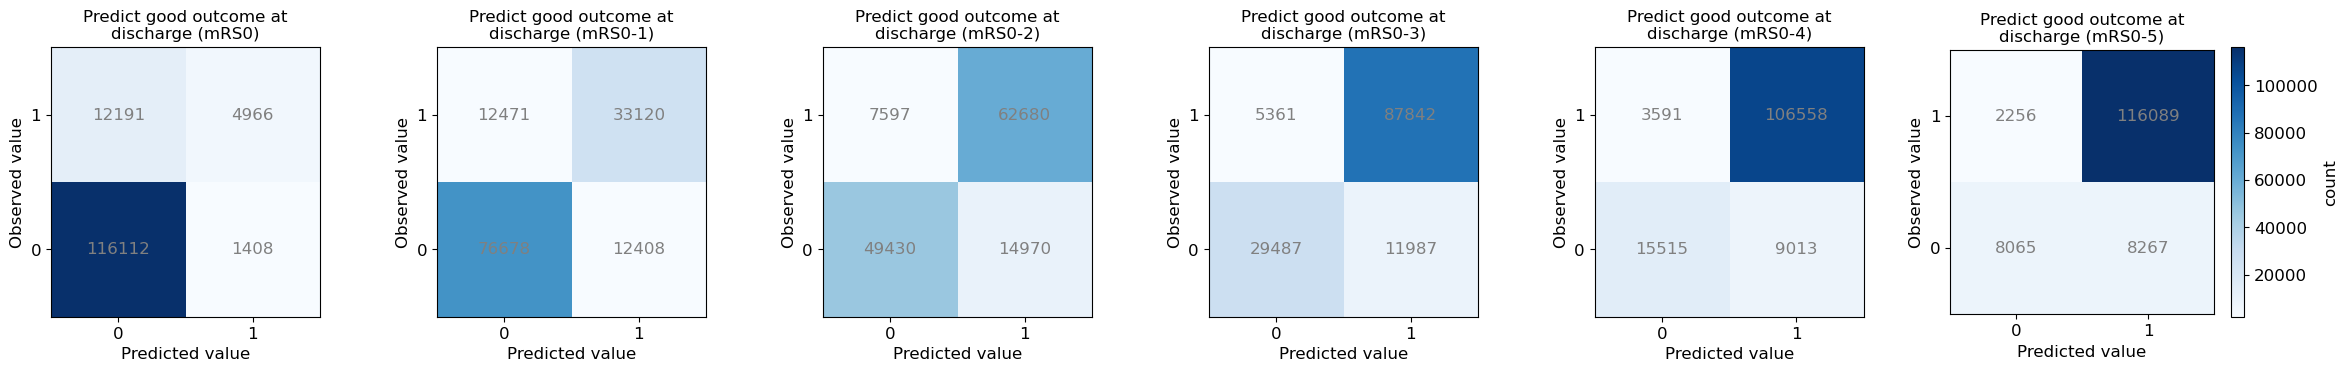

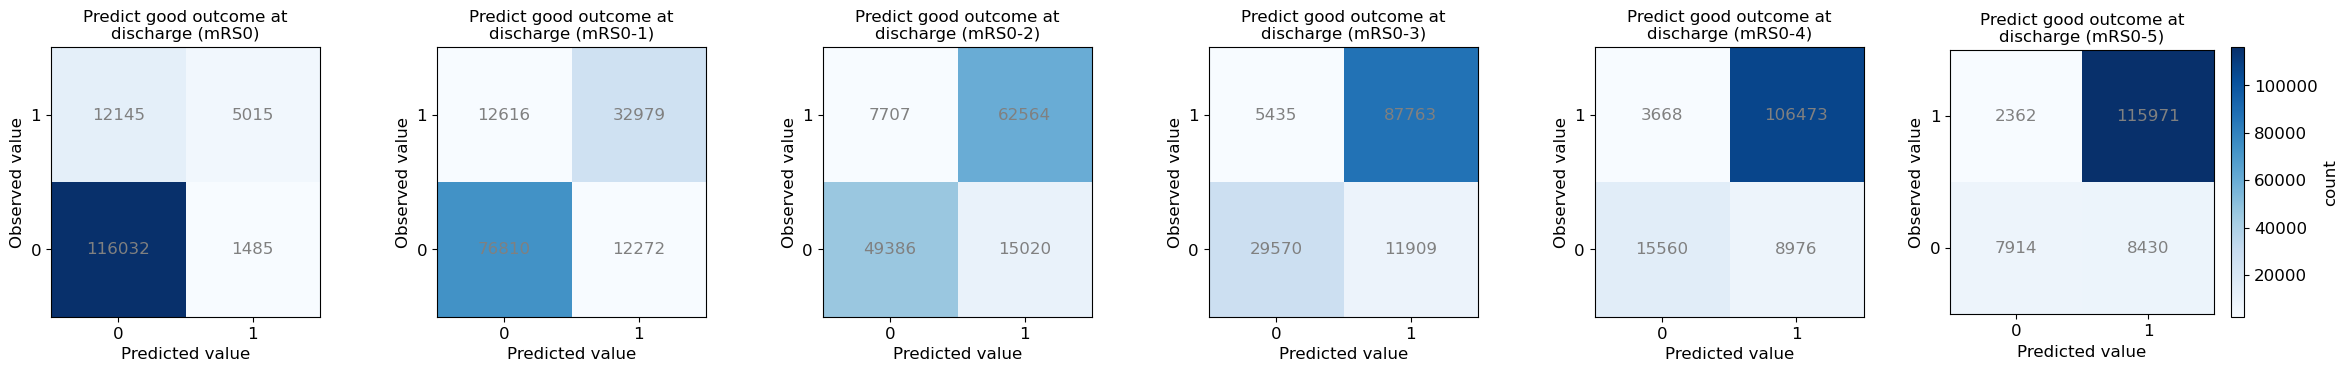

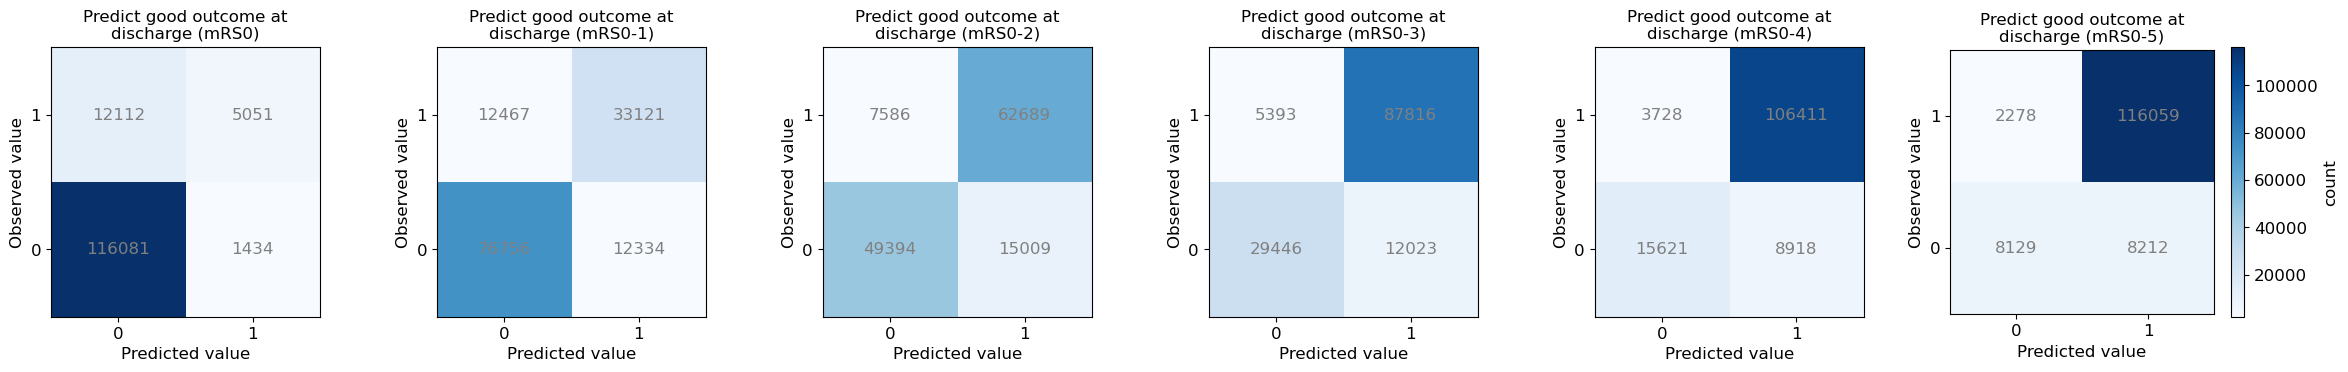

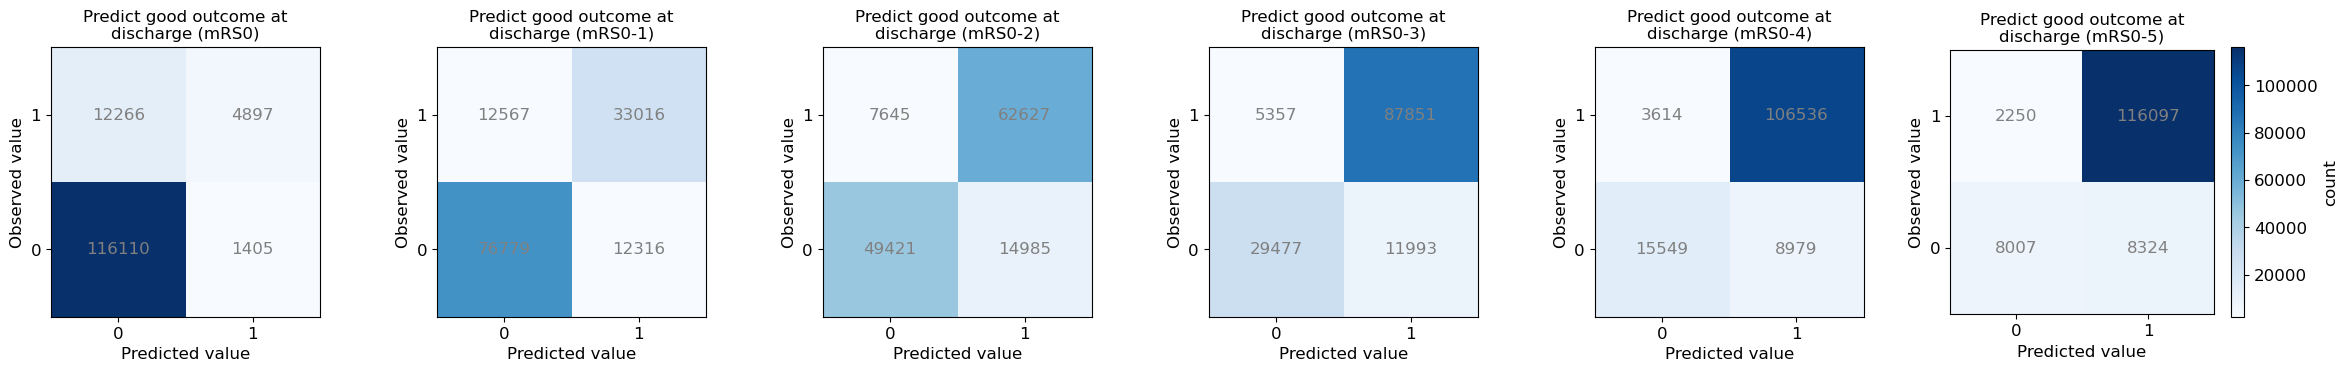

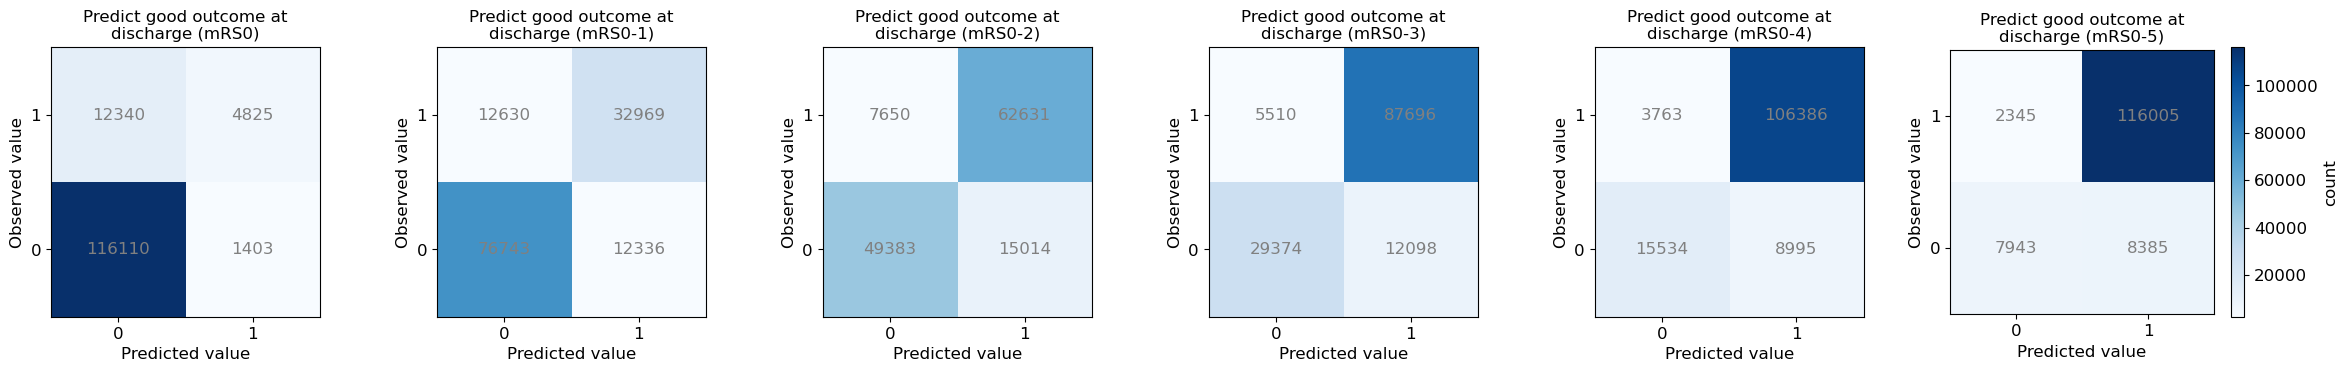

In [42]:
for k in range(n_kfold):
    # Store max to determine the common color bar for all confusion matrices
    for binary_threshold in list_binary_thresholds:

        # Set up the target feature name for this threshold
        binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

        # Get y_test binary for this threshold
        y_test_bin = list_df_all_y_bin_test_kfold[k][binary_target_feature_name]

        # Calculate values for confusion matrix
        cm = confusion_matrix(y_test_bin, dict_binary_model_results[f"y_pred_kfold_list_mrs{binary_threshold}"][k])

        vmax = np.max(cm)


# Define number subplots for the figure
nrows = 1
ncols = n_binary_models

for k in range(n_kfold):

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

#    if ncols > 1:
#        fig.suptitle(f'Confusion matrices (per binary threshold model) for kfold {k}', fontsize=20)
#        fig.suptitle(f'kfold {k}', fontsize=20)

    # Set figure size
    fig.set_size_inches(24,4)

    # Loop through the thresholds, create a confusion matrix per threshold
    for binary_threshold, ax in zip(list_binary_thresholds, axs):

        # Set up the target feature name for this threshold
        binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

        # Set axis title
        if binary_threshold == 0:
            title_str = "mRS0"
        else:
            title_str = f"mRS0-{binary_threshold}"

        ax.set_title(f'Predict good outcome at\ndischarge ({title_str})',
                    fontsize=12)

        # Get y_test binary for this threshold
        y_test_bin = list_df_all_y_bin_test_kfold[k][binary_target_feature_name]

        # Calculate values for confusion matrix
        cm = confusion_matrix(y_test_bin, 
                              dict_binary_model_results[f"y_pred_kfold_list_mrs{binary_threshold}"][k])
                              
        # Visualize the confusion matrix with colors
        heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower', vmax=vmax)
        if binary_threshold == list_binary_thresholds[-1]:
            cbar = plt.colorbar(heatmap, ax=ax, alpha=0.5, label='Count')#, shrink=shrink
            cbar.set_label(label='count', fontsize=12)
            for t in cbar.ax.get_yticklabels():
                 t.set_fontsize(12)

        # Add values to plot
        for i in range(len(cm)):
            for j in range(len(cm[0])):
                ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                        size=12)

        # Set axis titles
        ax.set_xlabel('Predicted value', fontsize=12)
        ax.set_ylabel('Observed value', fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xticks([0,1])
        ax.set_yticks([0,1])

    plt.tight_layout(rect=(0,0,1,0.85))

    filename = os.path.join(paths.image_save_path,
                            (paths.notebook + paths.model_text + 
                        f'_confusion_matrices_per_binary_threshold_kfold{k}.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show()

## Identify intersection of sensitivity and specificity

In [26]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

Calculate data for sensitivity-specificity curve:

In [27]:
def create_data_sensitivity_specificity(y_probs, y_test):
    

    # Set up list for accuracy measures
    sensitivity = []
    specificity = []

    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = y_probs >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_test, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])

    return(sensitivity, specificity)

Define function to create a combined plot: ROC and sensitivity-specificity

In [28]:
def create_combined_plot_rocauc_sensitivity_specificity(y_test_bin, y_probs, 
                    sensitivity, specificity, intersection, binary_threshold, k):

    """ 
    Args:
        y_test_bin [array]: observed value per test instance (for binary model)
        y_probs [array]: probability of being classified "1" in the binary model
        sensitivity [array]: Sensitivity of model using different thresholds
        specificity [array]: Specificity of model using different thresholds
        intersection [float]: Value at which mutual tradeoff between specificity 
                    and sensitivity
        binary_threshold [integer]: mRS threshold used to create binary model
        k [integer]: kfold split
    Return:
        None
    """

    fig = plt.figure(figsize=(10,5))

    fig.suptitle(f"Predicting is patient is at least as well as mRS"
                 f"{binary_threshold} at discharge (for {k} kfold)", fontsize=14)
    # Get ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    ax1 = fig.add_subplot(121)
    ax1.plot(fpr, tpr, color='orange')
    ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'Receiver Operator Characteristic Curve\nAUC: {roc_auc:.3f}')
    plt.grid(True)

    # Plot sensitivity-specificity
    ax2 = fig.add_subplot(122)
    ax2.plot(sensitivity, specificity)
    ax2.scatter(intersection,intersection, s=10, c="k")
    ax2.set_xlabel('Sensitivity')
    ax2.set_ylabel('Specificity')
    ax2.set_title(f'Sensitivity-Specificity Curve\nIntersection: '
                  f'{intersection:0.3f}')
    plt.grid(True)


    plt.tight_layout(pad=2)

    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + '_roc_sens_spec_mrs' + 
                            str(binary_threshold) + '_kfold' + str(k) + '.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show()

In [29]:
def create_combined_plot_rocauc_sensitivity_specificity_for_paper(
                    y_test_bin, y_probs, 
                    sensitivity, specificity, intersection, binary_threshold, k):

    """ 
    Args:
        y_test_bin [array]: observed value per test instance (for binary model)
        y_probs [array]: probability of being classified "1" in the binary model
        sensitivity [array]: Sensitivity of model using different thresholds
        specificity [array]: Specificity of model using different thresholds
        intersection [float]: Value at which mutual tradeoff between specificity 
                    and sensitivity
        binary_threshold [integer]: mRS threshold used to create binary model
        k [integer]: kfold split
    Return:
        None
    """

    fig = plt.figure(figsize=(10,5))
    if binary_threshold == 0:
        title_str = f"mRS{binary_threshold}"
    else:
        title_str = f"mRS0-{binary_threshold}"
    
    fig.suptitle(f"Predicting patient has a good outcome at discharge ({title_str})"
                 , fontsize=20)
    # Get ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    ax1 = fig.add_subplot(121)
    ax1.plot(fpr, tpr, color='orange')
    ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    ax1.set_xlabel('False Positive Rate', fontsize=16)
    ax1.set_ylabel('True Positive Rate', fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_title(f'Receiver Operator Characteristic Curve\nAUC: {roc_auc:.3f}', fontsize=16)
    plt.grid(True)

    # Plot sensitivity-specificity
    ax2 = fig.add_subplot(122)
    ax2.plot(sensitivity, specificity)
    ax2.scatter(intersection,intersection, s=10, c="k")
    ax2.set_xlabel('Sensitivity', fontsize=16)
    ax2.set_ylabel('Specificity', fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_title(f'Sensitivity-Specificity Curve\nIntersection: '
                  f'{intersection:0.3f}', fontsize=16)
    plt.grid(True)


    plt.tight_layout(pad=2)

    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + '_roc_sens_spec_mrs' + 
                            str(binary_threshold) + '_kfold' + str(k) + '_paper.jpg'))

    plt.savefig(filename, dpi=300)

    plt.show()

Identify cross-over point on sensitivity-specificity curve

Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [30]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

Create data and plot for each model (one for each binary model using each mRS threshold)

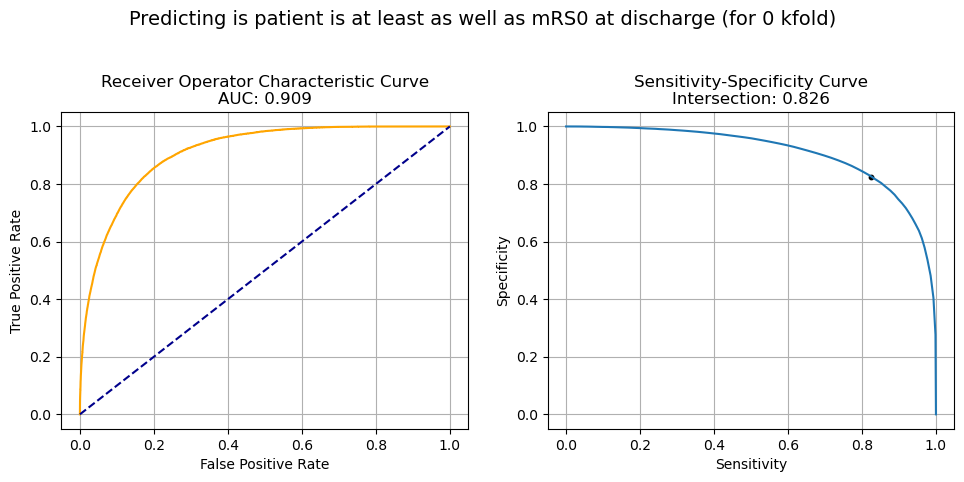

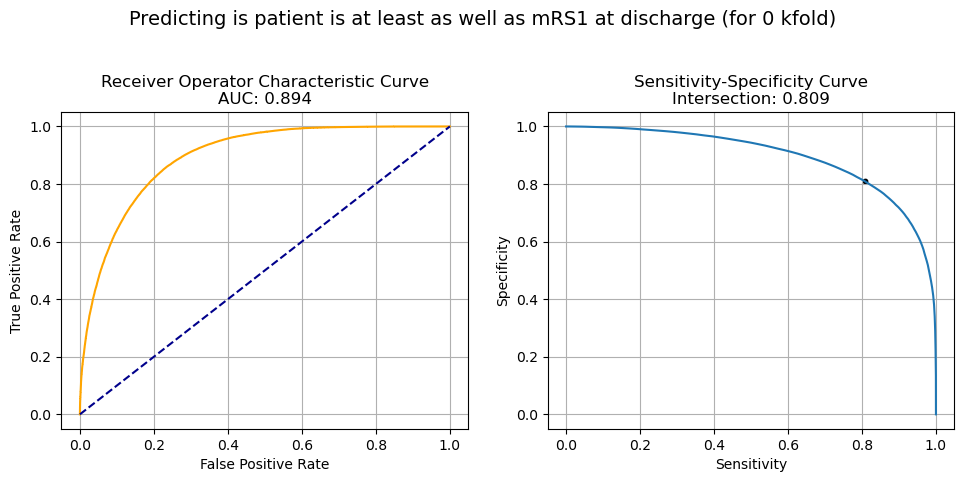

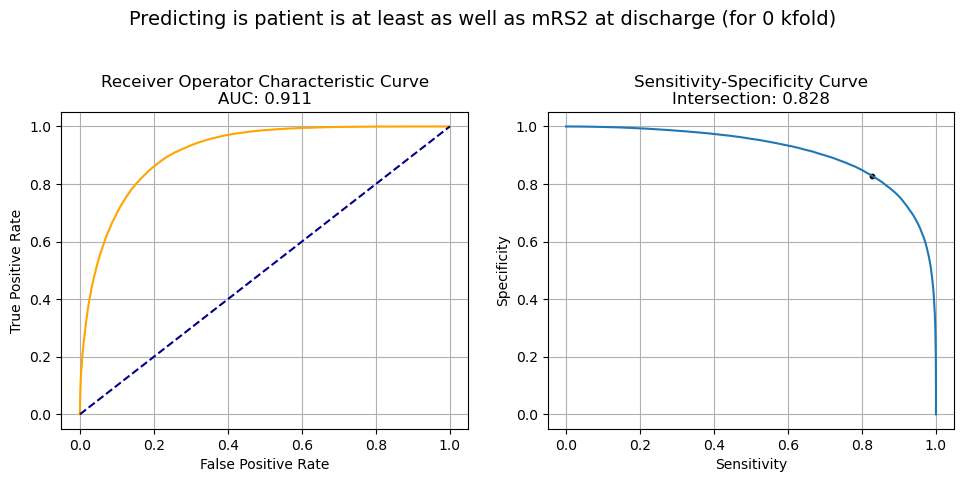

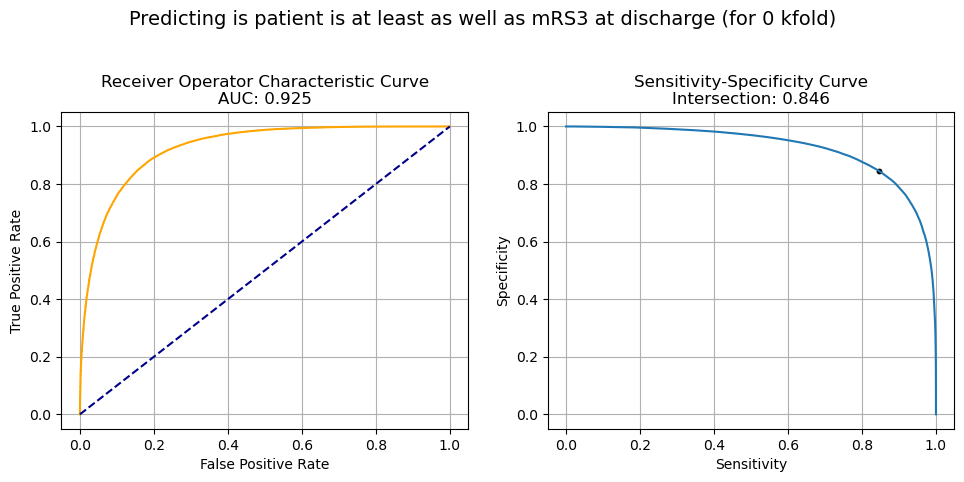

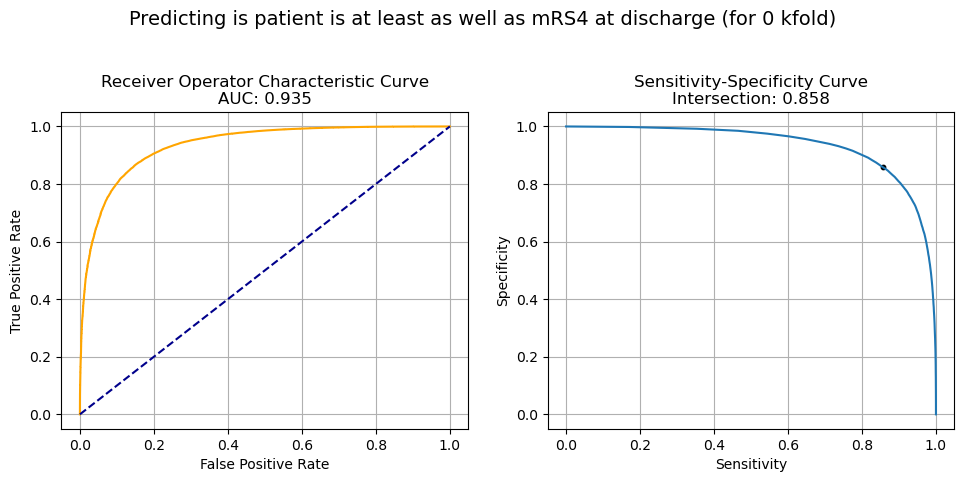

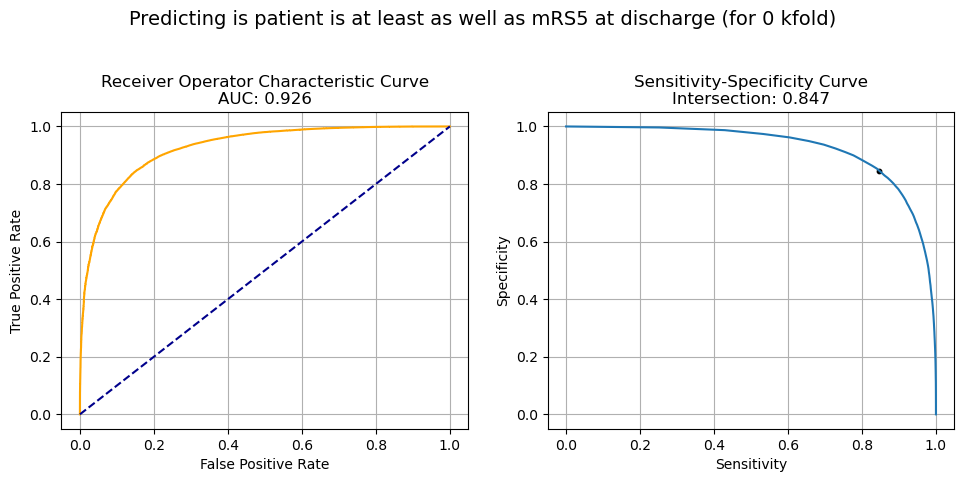

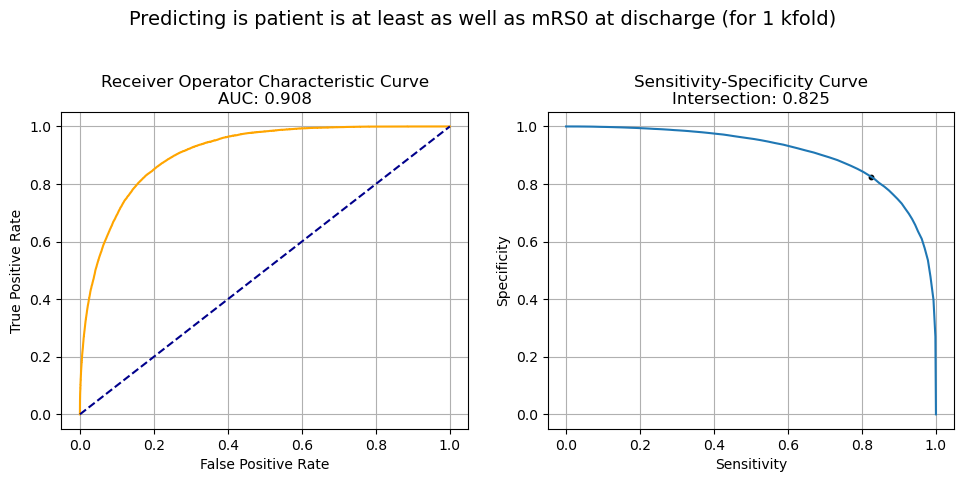

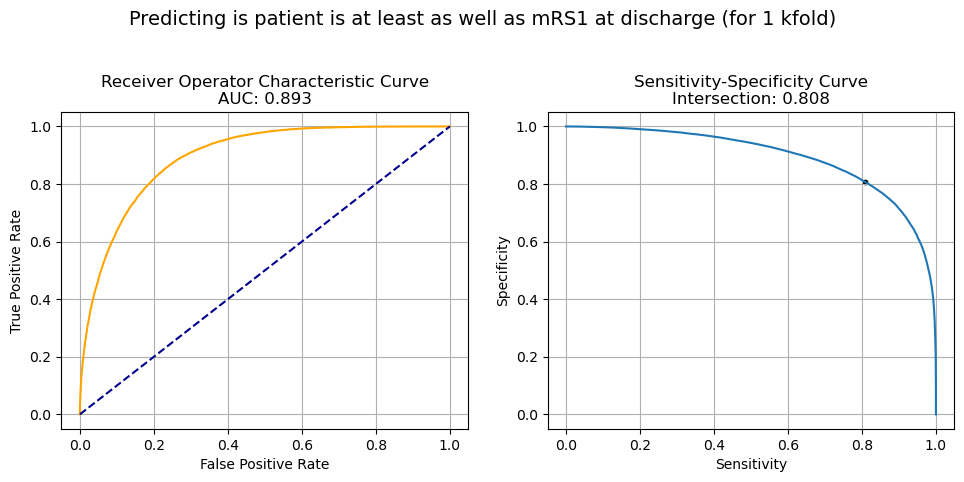

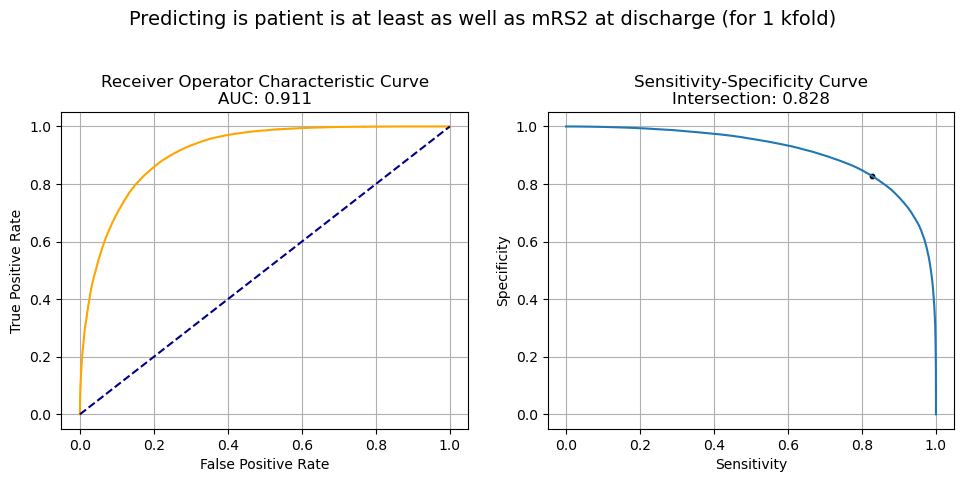

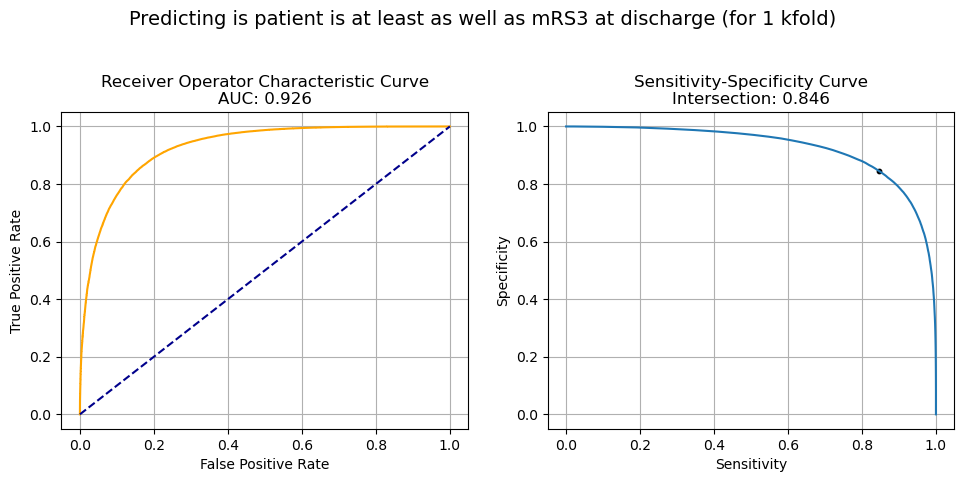

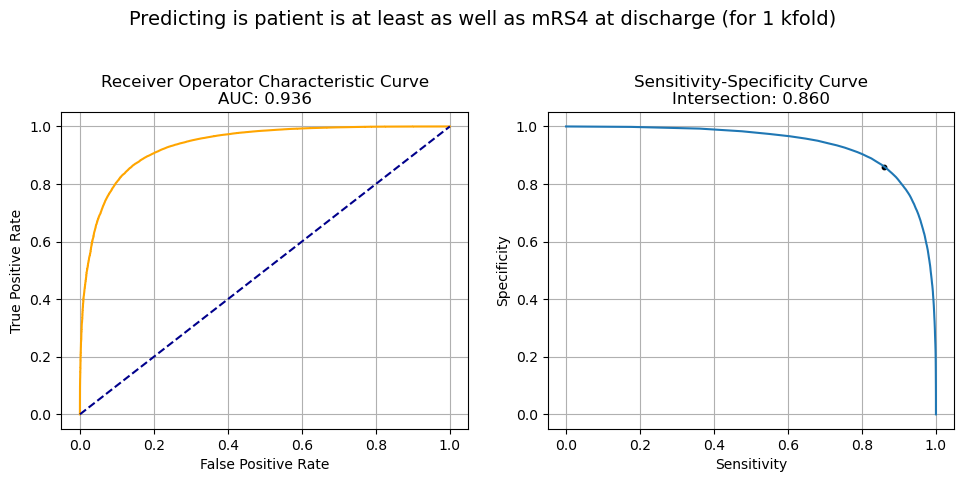

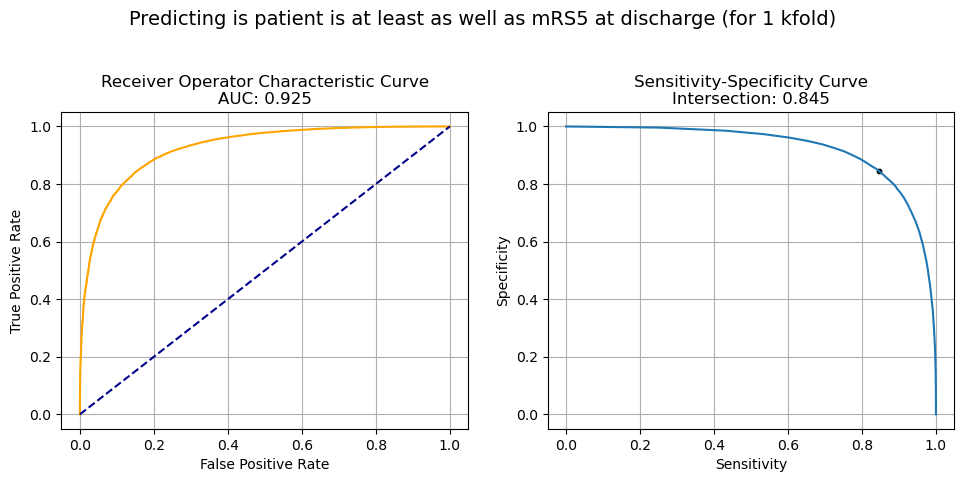

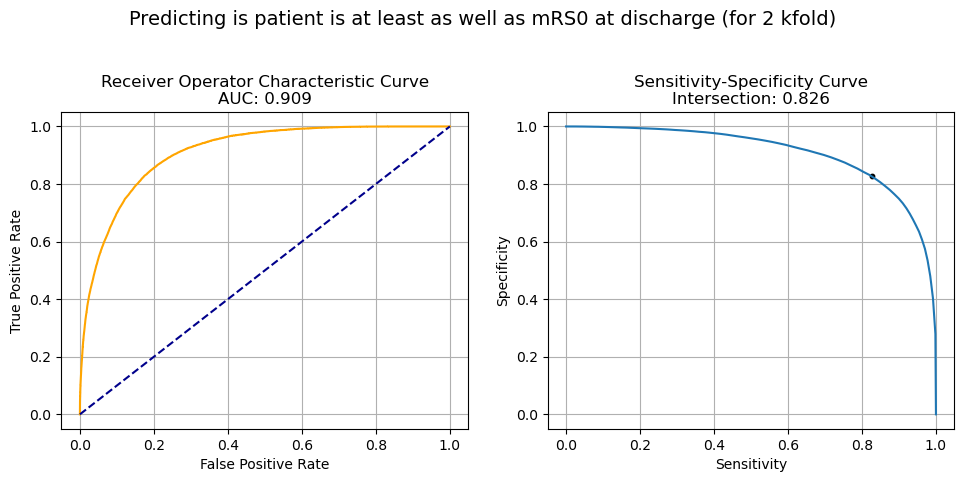

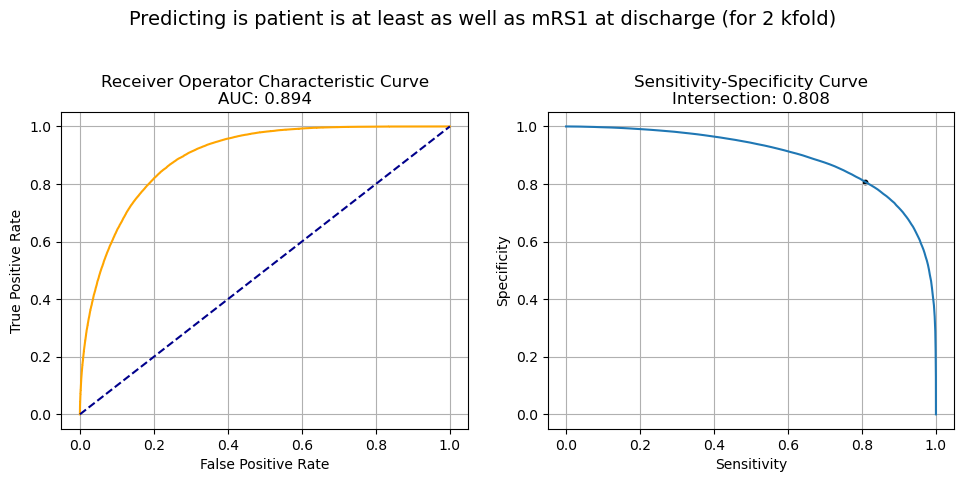

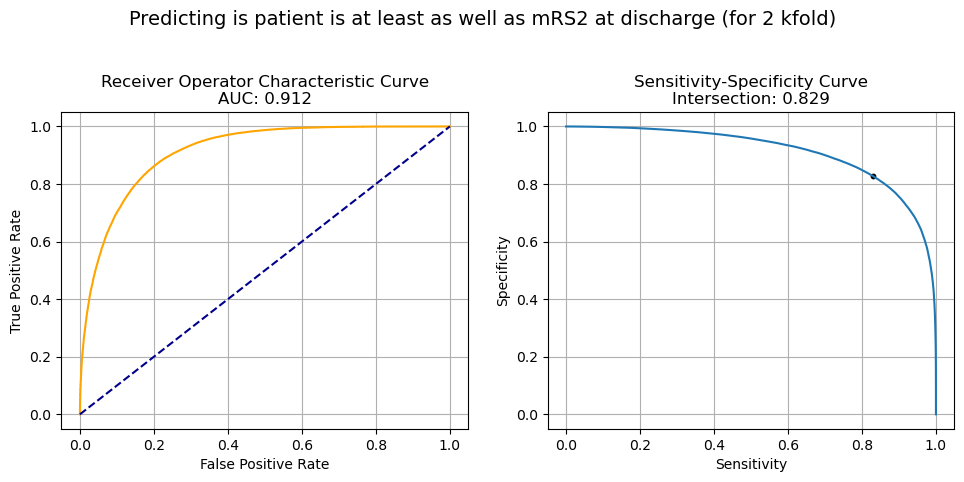

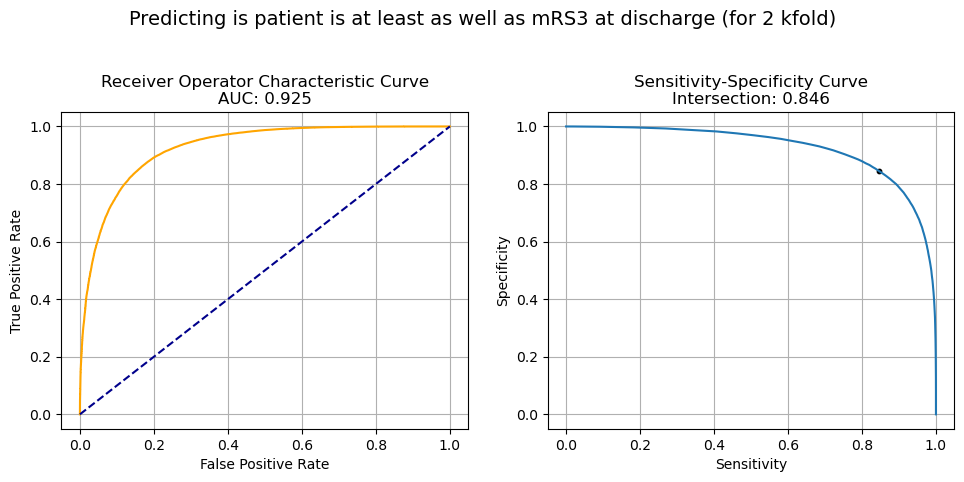

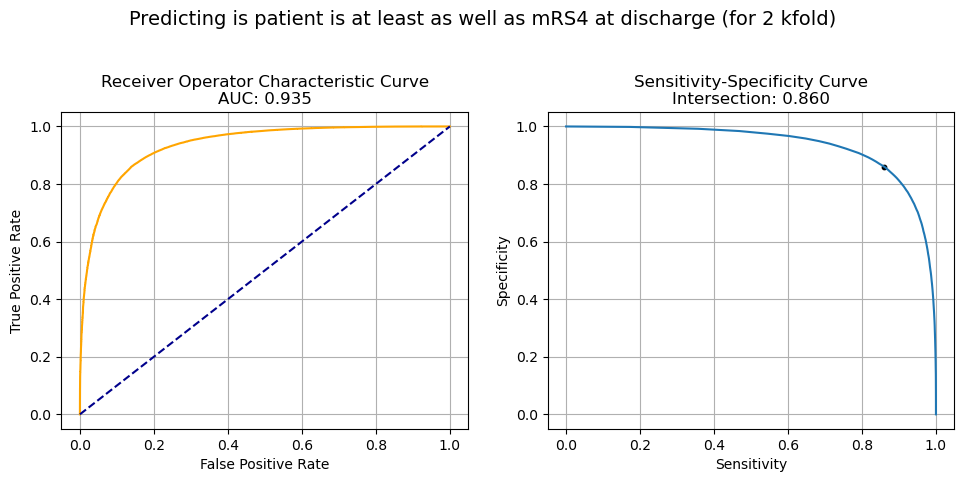

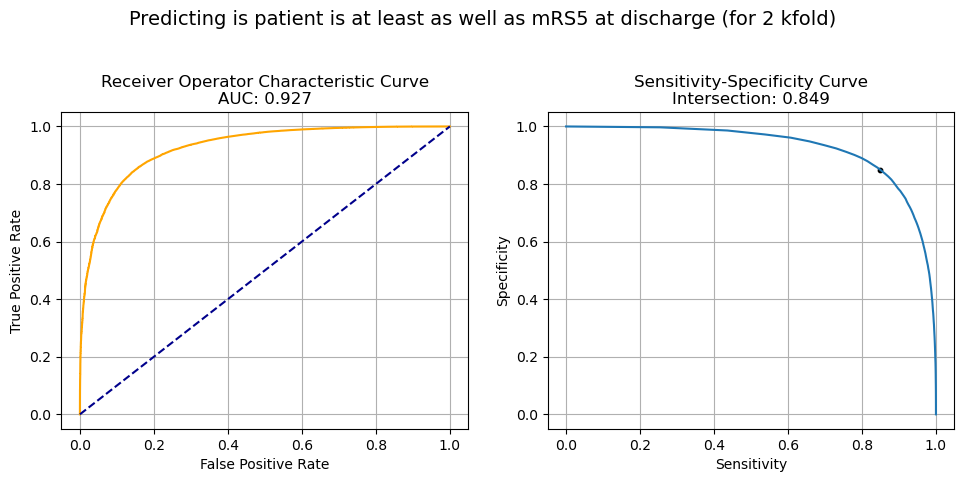

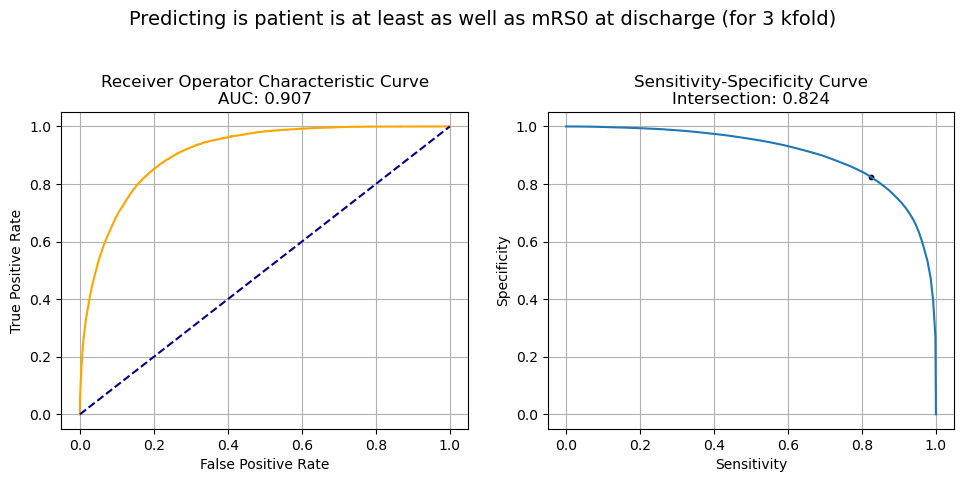

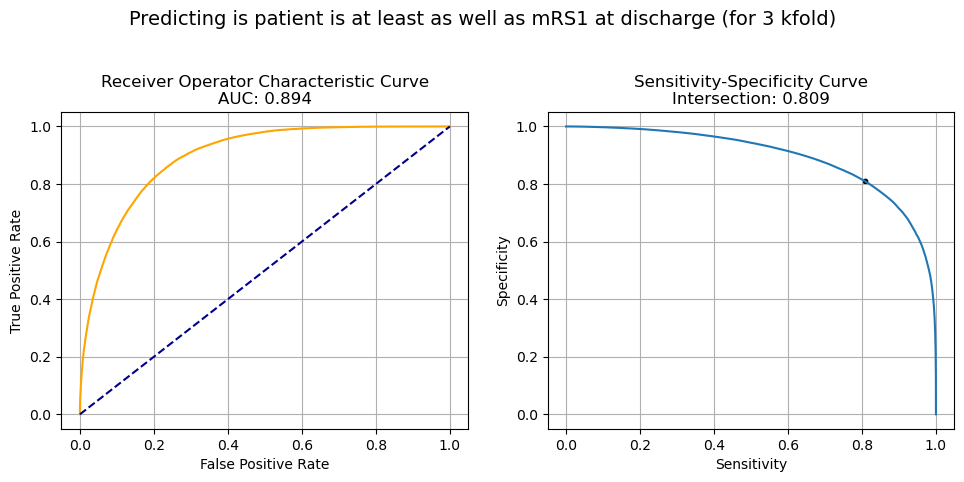

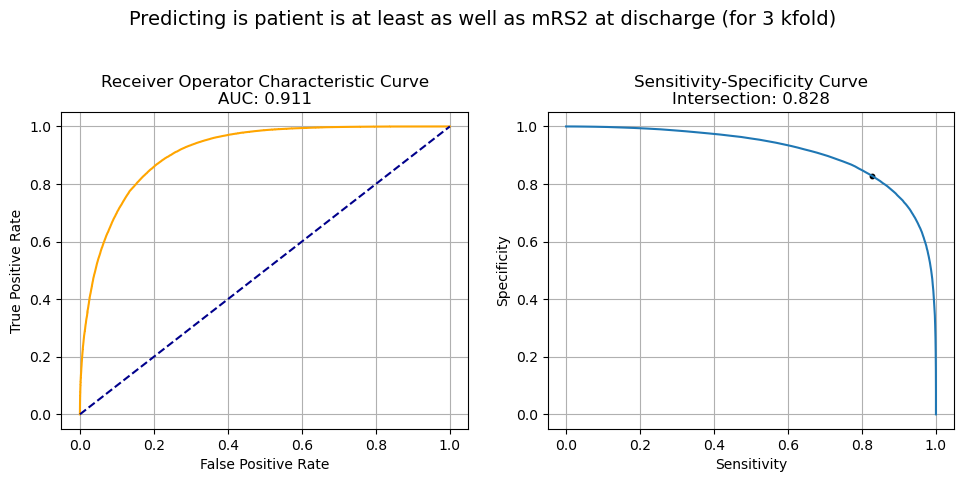

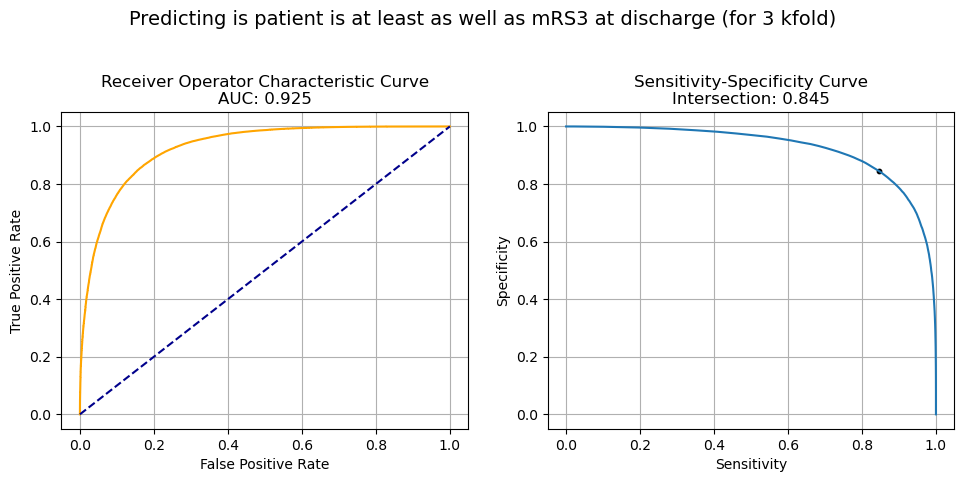

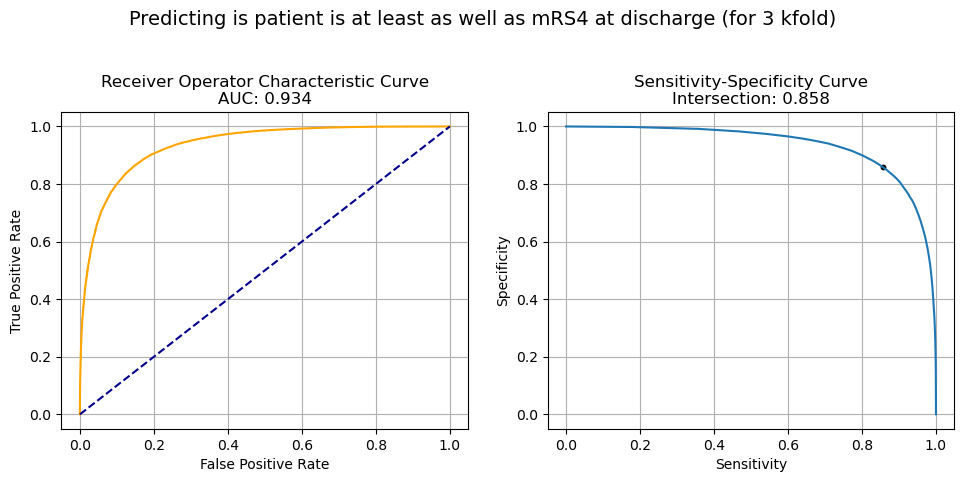

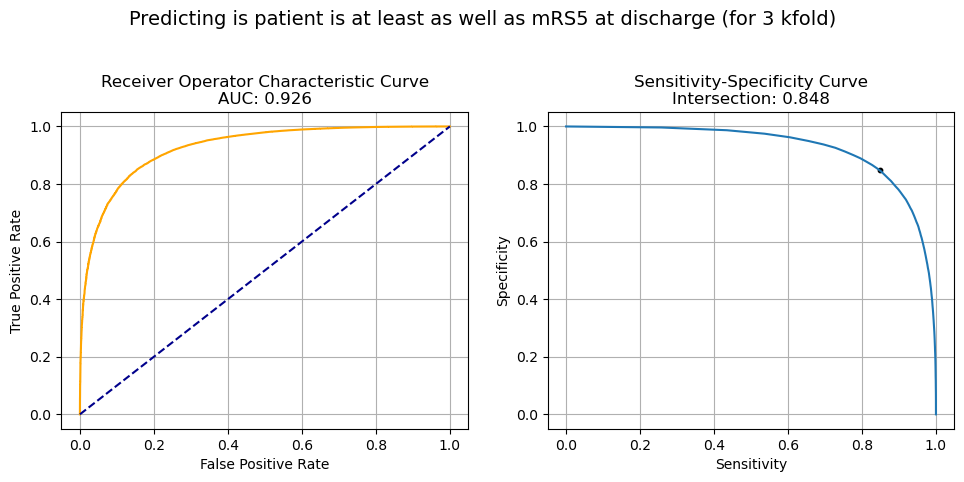

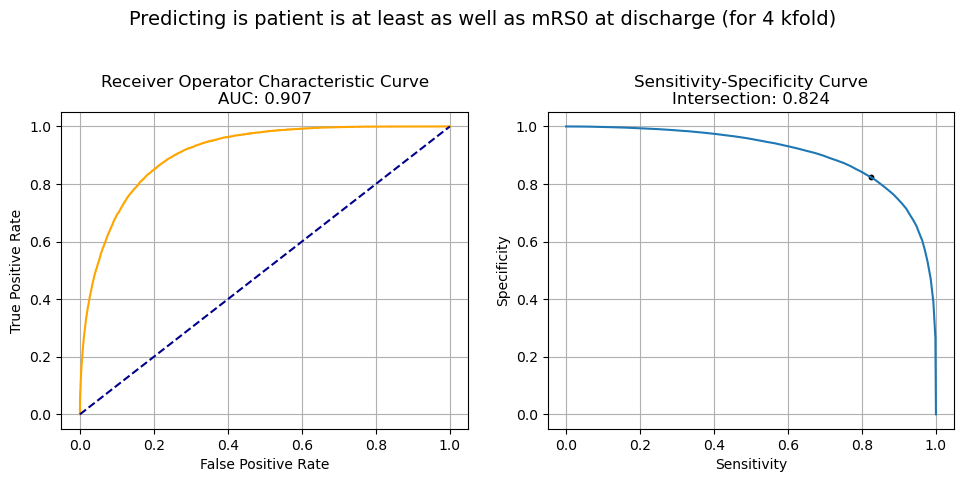

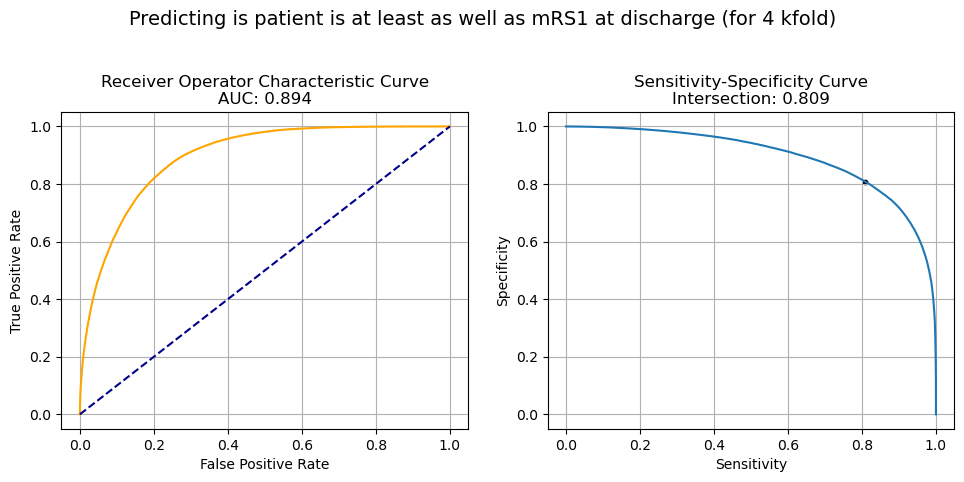

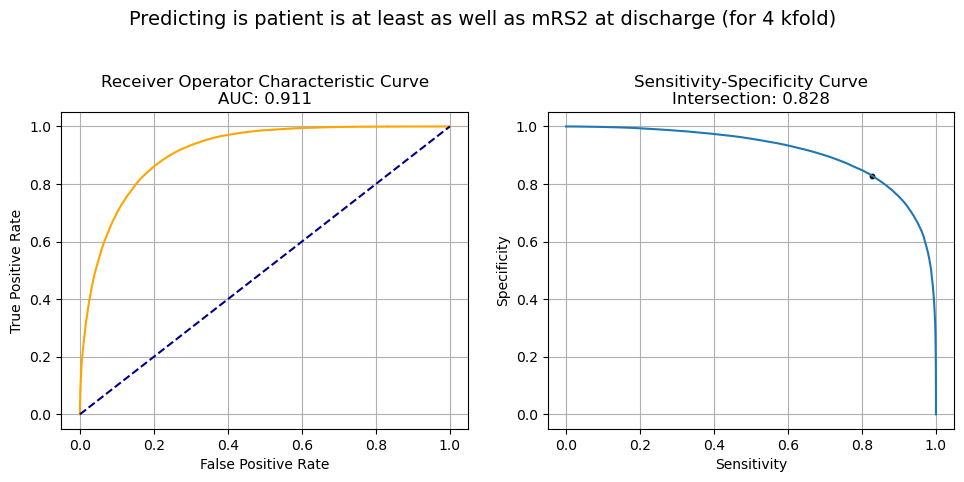

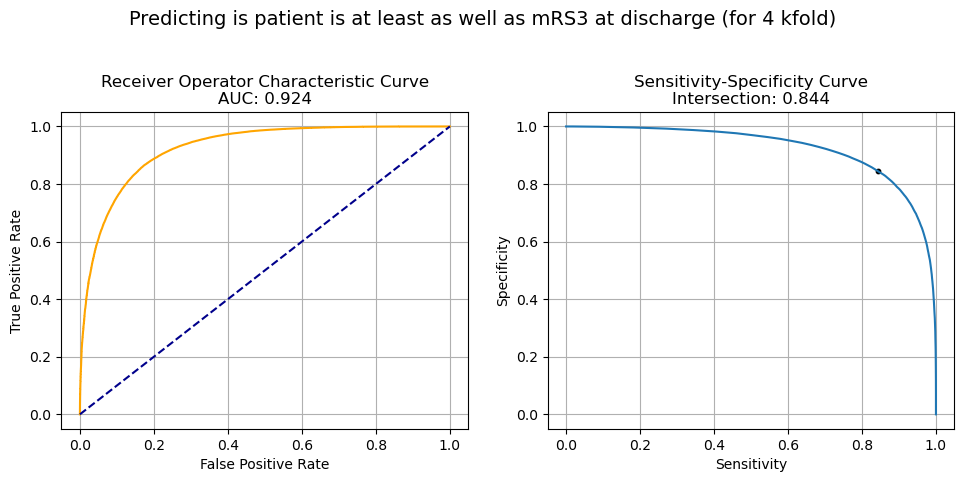

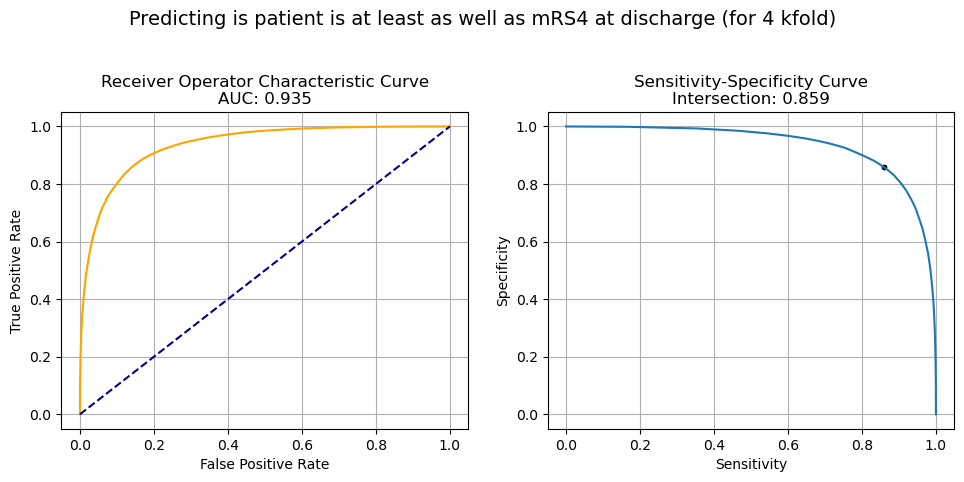

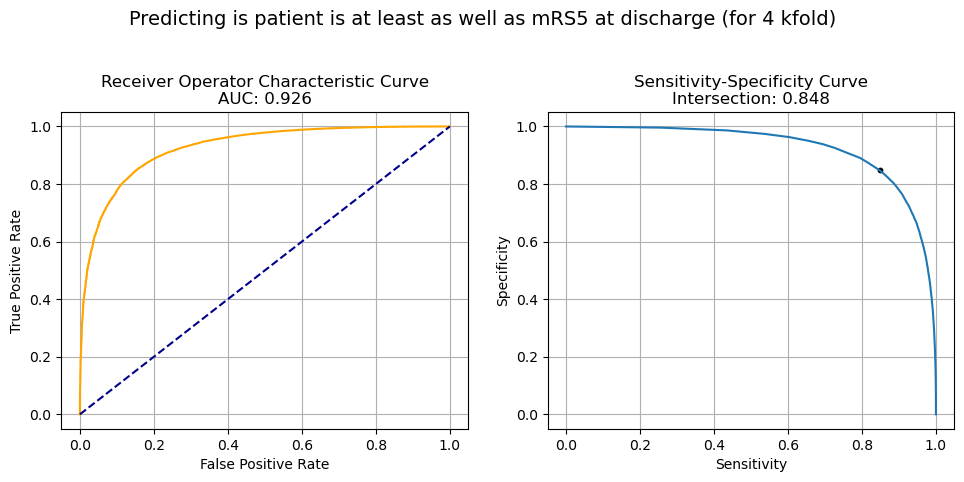

In [31]:
for k in range(n_kfold):
    # Set threshold to look at
    for binary_threshold in list_binary_thresholds:

        # Create the target feature name (for this binary case)
        binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

        # Get the y values for the test set for this threshold
        y_test_bin = list_df_all_y_bin_test_kfold[k][binary_target_feature_name]

        # Get the probabilities for each instance for this threshold model
        y_probs = dict_binary_model_results[f"y_probs_kfold_list_mrs{binary_threshold}"][k]

        # Get model for specified threshold
        model = dict_binary_model_results[f"model_kfold_list_mrs{binary_threshold}"][k]

        # Set up list for accuracy measures
        (sensitivity, specificity) = create_data_sensitivity_specificity(y_probs, y_test_bin)


        # Setup data for calculating intersection
        df = pd.DataFrame()
        df['sensitivity'] = np.array(sensitivity)
        df['specificity'] = np.array(specificity)
        df['spec greater sens'] = df['specificity'] > df['sensitivity']

        # find last index for senitivity being greater than specificity 
        mask = df['spec greater sens'] == False
        last_id_sens_greater_spec = np.max(df[mask].index)
        locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
        points = df.iloc[locs][['sensitivity', 'specificity']]

        # Get intersection with line of x=y
        a1 = list(points.iloc[0].values)
        a2 = list(points.iloc[1].values)
        b1 = [0, 0]
        b2 = [1, 1]

        intersection = get_intersect(a1, a2, b1, b2)[0]

        create_combined_plot_rocauc_sensitivity_specificity(y_test_bin, y_probs, 
                        sensitivity, specificity, intersection, 
                        binary_threshold, k)


As above, but formatted for the paper

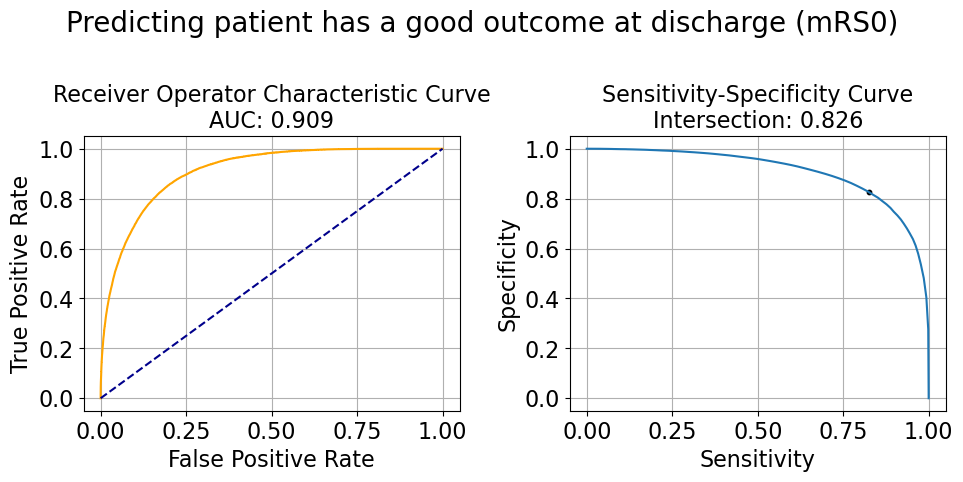

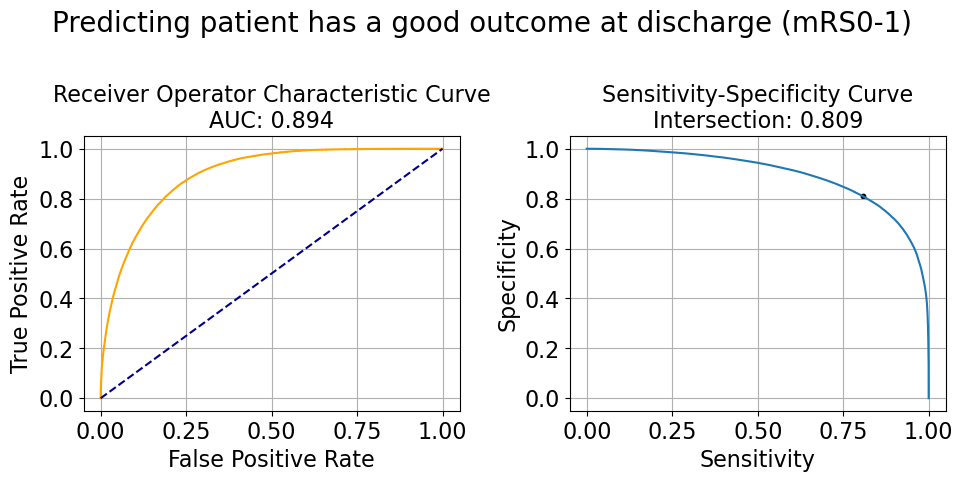

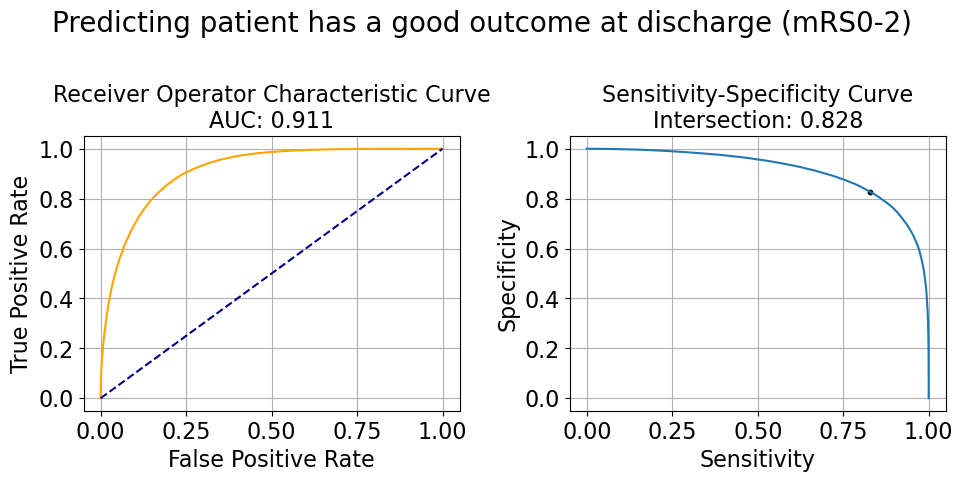

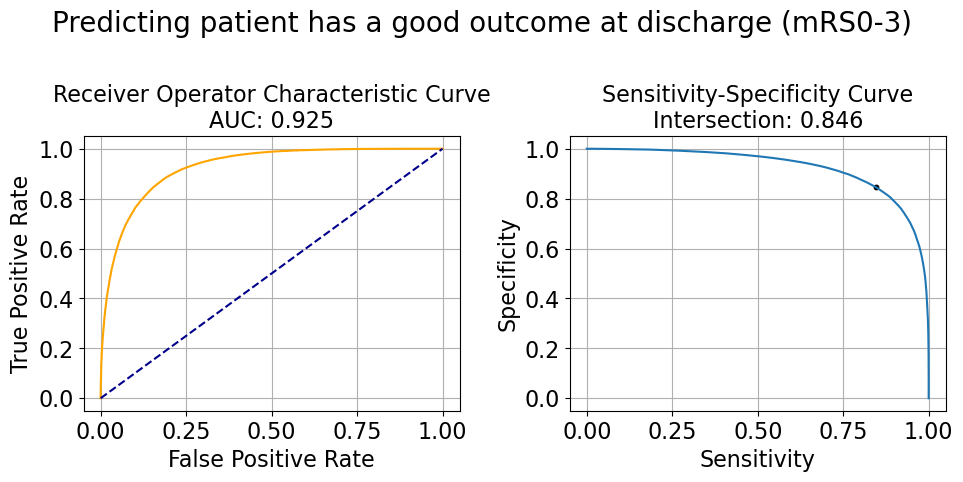

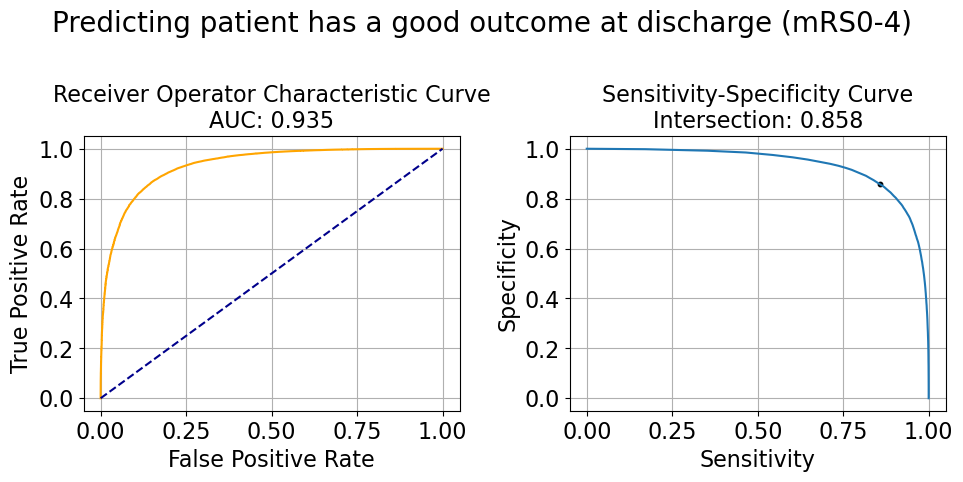

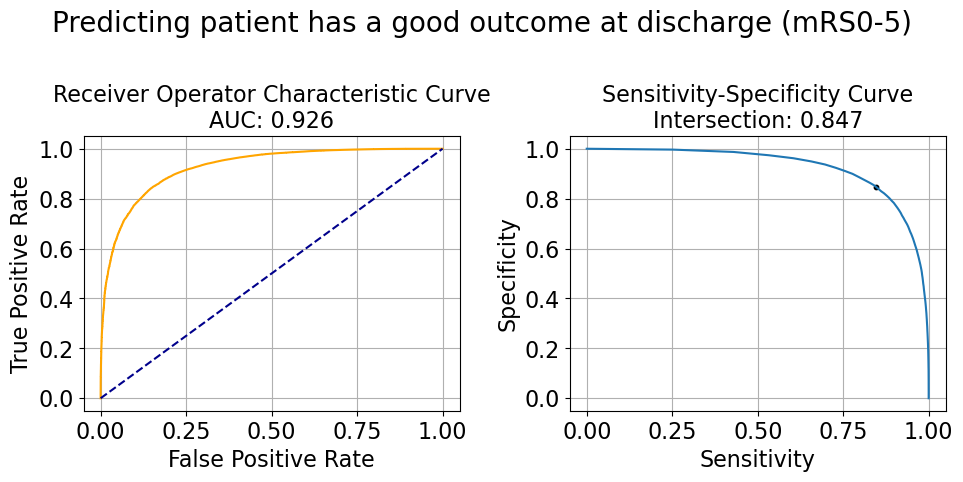

In [32]:
k = 0
# Set threshold to look at
for binary_threshold in list_binary_thresholds:

    # Create the target feature name (for this binary case)
    binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

    # Get the y values for the test set for this threshold
    y_test_bin = list_df_all_y_bin_test_kfold[k][binary_target_feature_name]

    # Get the probabilities for each instance for this threshold model
    y_probs = dict_binary_model_results[f"y_probs_kfold_list_mrs{binary_threshold}"][k]

    # Get model for specified threshold
    model = dict_binary_model_results[f"model_kfold_list_mrs{binary_threshold}"][k]

    # Set up list for accuracy measures
    (sensitivity, specificity) = create_data_sensitivity_specificity(y_probs, y_test_bin)


    # Setup data for calculating intersection
    df = pd.DataFrame()
    df['sensitivity'] = np.array(sensitivity)
    df['specificity'] = np.array(specificity)
    df['spec greater sens'] = df['specificity'] > df['sensitivity']

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersection with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersection = get_intersect(a1, a2, b1, b2)[0]

    create_combined_plot_rocauc_sensitivity_specificity_for_paper(
        y_test_bin, y_probs, sensitivity, specificity, intersection, 
                    binary_threshold, k)

Duration to run notebook

In [43]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'3:05:38.431481'